In [1]:
import os, glob
from sklearn import preprocessing
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math


In [2]:
dataset_path = os.getcwd()+'/FaceDataset/'# path to the dataset

In [3]:

def plot_image(images, titles, h,w,n_row,n_col):
    plt.figure(figsize=(2.2*n_col,2.2*n_row))
    plt.subplots_adjust(bottom=0,left=.01,right=.99,top=.90,hspace=.20)
    for i in range(n_row*n_col):
        plt.subplot(n_row,n_col,i+1)
        plt.imshow(images[i].reshape((h,w)),cmap=plt.cm.gray)
        plt.title(titles[i])
        plt.xticks(())
        plt.yticks(())

In [4]:
tot_images =0
shape = None
for images in glob.glob(dataset_path + '/**', recursive=True):#Loop through all the images in the folder
    if images[-3:] == 'pgm' or images[-3:] == 'jpg':
        tot_images += 1
print(tot_images)#Number of m is 400

400


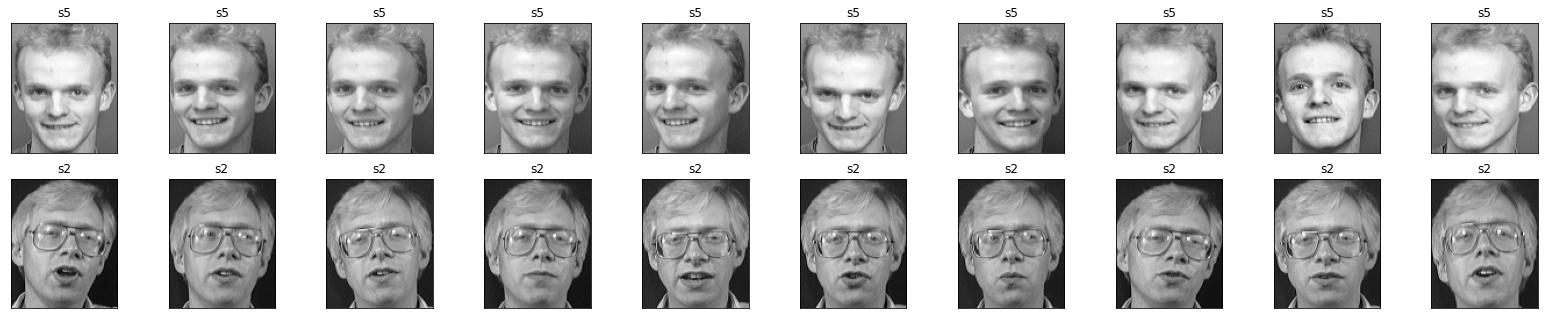

In [17]:
shape = (112,92)#height of the image is 112 and width is 92
all_img = np.zeros((tot_images,shape[0],shape[1]),dtype='float64')#Creating 0 matrix with 112 rows and 92 columns of zeros for 400 images
names = list()
i=0
for folder in glob.glob(dataset_path + '/*'):#Loop through folders
    for _ in range(10):
        names.append(folder[-3:].replace('/',''))
    for image in glob.glob(folder +'/*'):#Loop through images
        read_image = cv2.imread(image,cv2.IMREAD_GRAYSCALE)
        resized_image =cv2.resize(read_image,(shape[1],shape[0]))#cv2.resize resizes an image into (# column x # height)
        all_img[i]=np.array(resized_image)
        i+=1

plot_image(all_img,names,112,92,2,10)
        

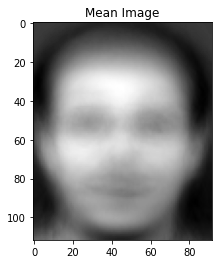

In [6]:
A = np.resize(all_img,(tot_images,shape[0]*shape[1]))#Creating a matrix of n^2 x m
mean_vector = np.sum(A,axis=0,dtype='float64')/tot_images
mean_matrix = np.tile(mean_vector,(tot_images,1))#Calculating mean for all the 400 images
A_tilde = A - mean_matrix# Matrix A - the mean value of all the images
plt.imshow(np.resize(mean_vector,(shape[0],shape[1])),cmap='gray')#display the mean image vector
plt.title('Mean Image')
plt.show()

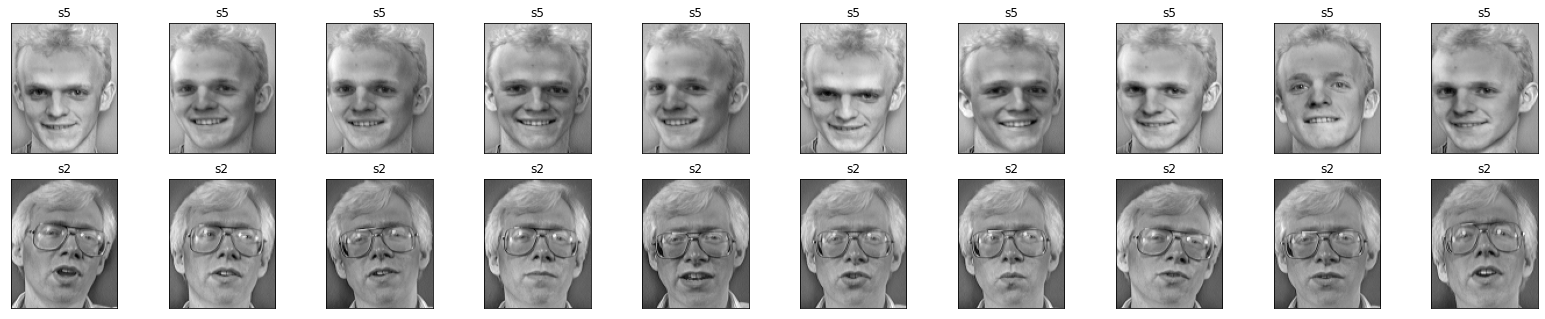

In [7]:
plot_image(A_tilde,names,112,92,2,10)#Images with zero mean matrix

In [8]:
L =(A_tilde.dot(A_tilde.T))/tot_images#Creating a m x m symmetric matrix
print("L shape:", L.shape)
eigenvalues,eigenvectors = np.linalg.eig(L)# Calculating the eigenvalues and eigenvectors
idx = eigenvalues.argsort()[::-1]#sort eigenvalues in descending order
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]#Sort the eigenvectors according to the highest eigenvalues

L shape: (400, 400)


In [9]:
eigenvector_C = A_tilde.T @ eigenvectors# perform linear combination with Matrix A_tilde
eigenvector_C.shape#Each column is an eigenvector

(10304, 400)

In [10]:
eigenfaces = preprocessing.normalize(eigenvector_C.T)#Normalize the vector
eigenfaces.shape

(400, 10304)

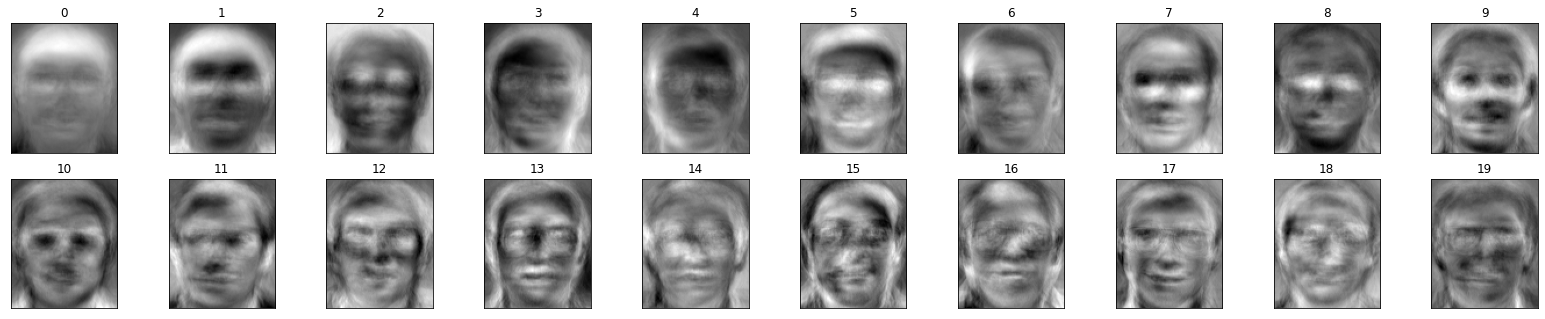

In [11]:
eigenface_labels = [x for x in range(eigenfaces.shape[0])]#List of images 
plot_image(eigenfaces,eigenface_labels,112,92,2,10)#Display image using eigenvectors for each image

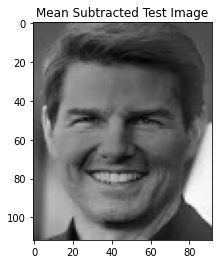

In [12]:
test_img = cv2.imread('test.jpeg', cv2.IMREAD_GRAYSCALE)
test_img = cv2.resize(test_img,(shape[1],shape[0]))#resize the test image to 92 x 112
mean_sub_testimg=np.reshape(test_img,(test_img.shape[0]*test_img.shape[1]))-mean_vector#Subtract test image with the mean value
plt.imshow(np.reshape(mean_sub_testimg,(112,92)),cmap='gray')
plt.title("Mean Subtracted Test Image")
plt.show()
                            

In [18]:
q=350 # 350 eigenvectors is chosen
E = eigenfaces[:q].dot(mean_sub_testimg)#Projecting the test image into the face space
E.shape

(350,)

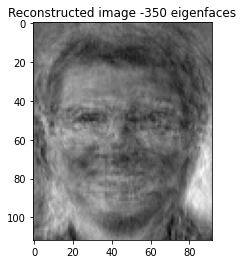

In [19]:
reconstruction = eigenfaces[:q].T.dot(E)#Reconstruct the test image using eigenvectors
reconstruction.shape

plt.imshow(np.reshape(reconstruction,(shape[0],shape[1])),cmap='gray')
plt.title("Reconstructed image -"+ str(q)+" eigenfaces")
plt.show()

In [20]:
# Detect Face
thres_1 = 3000 # Chosen threshold to detect face
projected_new_img_vect=eigenfaces[:q].T @ E#Perform Linear combination for the new face space
diff = mean_sub_testimg-projected_new_img_vect
beta = math.sqrt(diff.dot(diff))#Find the difference between the projected test image vector and the mean vector of the images

if beta<thres_1:
    print("Face Detected in the image!", beta)
else:
    print("No face Detected in the image!", beta)

Face Detected in the image! 2594.6904600156654


In [22]:
#Classify the image belongs to which class
thres_2 = 3000
smallest_value =None # to keep track of the smallest value
index = None #to keep track of the class that produces the smallest value
for z in range(tot_images):#Loop through all the image vectors
    E_z=eigenfaces[:q].dot(A_tilde[z])#Calculate and represent the vectors of the image in the dataset
    diff = E-E_z
    epsilon_z = math.sqrt(diff.dot(diff))
    if smallest_value==None:
        smallest_value=epsilon_z
        index = z
    if smallest_value>epsilon_z:
        smallest_value=epsilon_z
        index=z
if smallest_value<thres_2:
    print(smallest_value,names[index])
else:
    print(smallest_value,"unknown Face")

4900.846640827001 unknown Face
